In [421]:
from qiskit import QuantumProgram
from math import pi
import math
import numpy as np
import Qconfig

In [773]:
# We choose A = (1.5 0.5;0.5 1.5)
# For this eigenvectors are |-> and |+> with 1 and 2 as eigenvalues
# The idea is to first write A as R^T \Lambda R, where \Lambda has the eigenvalues in the diagonal
# R for this system is same as H, the Hadamard operator
A = np.empty((2,2))
A[0,0] = 1.5
A[0,1] = 0.5
A[1,0] = 0.5
A[1,1] = 1.5

# Eigenvalues of A are 1 and 2 with |-> and |+> being the corresponding eigen vectors

Q_program = QuantumProgram()

# We are solving a 2x2 system
# one ancilla qubit; q[3]
# two register qubits; q[1] and q[2]
# one input (b vector) qubit; q[0]

# Create 4 qubits
qr = Q_program.create_quantum_register('qr', 4)
cr = Q_program.create_classical_register('cr', 4)

#Create circuit
qc = Q_program.create_circuit('linear_solve', [qr], [cr])

# Step 1: Operating R matrix on b (stored in q[0])
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.cx(qr[1], qr[2])
qc.x(qr[1])
qc.swap(qr[1], qr[2])

# Step 2: Controlled rotation to get 1/lambda_1 and 1/lambda_2
qc.cu3(pi, 0.0, 0.0, qr[1], qr[3]) #controlled u3
qc.cu3(pi/3, 0.0, 0.0, qr[2], qr[3]) #controlled u3

# # Step 3: disentanglement -- essentially applying R^T on \Lambda*R*b
# # Reverse of Step 1
qc.swap(qr[1], qr[2])
qc.x(qr[1])
qc.cx(qr[1], qr[2])
qc.cx(qr[0], qr[1])
qc.h(qr[0])

# Circuits for b values
# We consider three b vectors (zero [1;0], minus [1/sqrt(2);-1/sqrt(2)] and plus [1/sqrt(2);1/sqrt(2)])
b_zero = Q_program.create_circuit('b_zero', [qr], [cr])

b_plus = Q_program.create_circuit('b_plus', [qr], [cr])
b_plus.h(qr[0])

b_minus = Q_program.create_circuit('b_minus', [qr], [cr])
b_minus.x(qr[0])
b_minus.h(qr[0])

# quantum circuit to measure q in standard basis 
measureZ = Q_program.create_circuit('measureZ', [qr], [cr])
for i in range(4):
    measureZ.measure(qr[i], cr[i])

# quantum circuit to measure q in superposition basis 
measureX = Q_program.create_circuit('measureX', [qr], [cr])
measureX.h(qr[0])
for i in range(4):
    measureX.measure(qr[i], cr[i])

# quantum circuit to measure q in superposition basis 
measureY = Q_program.create_circuit('measureY', [qr], [cr])
measureY.sdg(qr[0])
measureY.h(qr[0])
for i in range(4):
    measureY.measure(qr[i], cr[i])
    
#ibmqx4
coupling_map = {1: [0], 2: [0, 1, 4], 3: [2, 4]}

# execute the quantum circuit 
backend = 'local_qasm_simulator' # the device to run on
shots = 1000

# Print openqasm 
b_val_dict = {}
b_val_dict['b_zero'] = b_zero
b_val_dict['b_plus'] = b_plus
b_val_dict['b_minus'] = b_minus

measure_dict = {}
measure_dict['measureX'] = measureX
measure_dict['measureY'] = measureY
measure_dict['measureZ'] = measureZ

circuits = []
for b_key in b_val_dict.keys():
    for measure_key in measure_dict.keys(): 
        circuit = b_key + '_ls_' + measure_key
        Q_program.add_circuit(circuit, b_val_dict[b_key]+qc+measure_dict[measure_key] )
        circuits.append(circuit)

print(circuits)

[ 0.9486833  -0.31622777]
['b_zero_ls_measureX', 'b_zero_ls_measureY', 'b_zero_ls_measureZ', 'b_plus_ls_measureX', 'b_plus_ls_measureY', 'b_plus_ls_measureZ', 'b_minus_ls_measureX', 'b_minus_ls_measureY', 'b_minus_ls_measureZ']
pre-mapping properties: {'size': 29, 'depth': 24, 'width': 4, 'bits': 4, 'factors': 1, 'operations': {'u1': 2, 'u2': 3, 'cx': 14, 'u3': 6, 'measure': 4}}
initial layout: None
final layout: {('qr', 0): ('q', 1), ('qr', 1): ('q', 0), ('qr', 2): ('q', 2), ('qr', 3): ('q', 4)}
post-mapping properties: {'size': 59, 'depth': 39, 'width': 5, 'bits': 4, 'factors': 2, 'operations': {'u1': 4, 'u2': 26, 'cx': 20, 'u3': 5, 'measure': 4}}
pre-mapping properties: {'size': 30, 'depth': 25, 'width': 4, 'bits': 4, 'factors': 1, 'operations': {'u1': 3, 'u2': 3, 'cx': 14, 'u3': 6, 'measure': 4}}
initial layout: None
final layout: {('qr', 0): ('q', 1), ('qr', 1): ('q', 0), ('qr', 2): ('q', 2), ('qr', 3): ('q', 4)}
post-mapping properties: {'size': 64, 'depth': 41, 'width': 5, 'bits

In [812]:
# print(Q_program.get_qasms(circuits))
result = Q_program.execute(circuits, backend=backend, shots=shots, coupling_map=coupling_map, silent=False)

pre-mapping properties: {'size': 29, 'depth': 24, 'width': 4, 'bits': 4, 'factors': 1, 'operations': {'u1': 2, 'u2': 3, 'cx': 14, 'u3': 6, 'measure': 4}}
initial layout: None
final layout: {('qr', 0): ('q', 1), ('qr', 1): ('q', 0), ('qr', 2): ('q', 2), ('qr', 3): ('q', 4)}
post-mapping properties: {'size': 59, 'depth': 39, 'width': 5, 'bits': 4, 'factors': 2, 'operations': {'u1': 4, 'u2': 26, 'cx': 20, 'u3': 5, 'measure': 4}}
pre-mapping properties: {'size': 30, 'depth': 25, 'width': 4, 'bits': 4, 'factors': 1, 'operations': {'u1': 3, 'u2': 3, 'cx': 14, 'u3': 6, 'measure': 4}}
initial layout: None
final layout: {('qr', 0): ('q', 1), ('qr', 1): ('q', 0), ('qr', 2): ('q', 2), ('qr', 3): ('q', 4)}
post-mapping properties: {'size': 64, 'depth': 41, 'width': 5, 'bits': 4, 'factors': 2, 'operations': {'u1': 5, 'u2': 31, 'cx': 20, 'u3': 4, 'measure': 4}}
pre-mapping properties: {'size': 28, 'depth': 23, 'width': 4, 'bits': 4, 'factors': 1, 'operations': {'u1': 2, 'u2': 2, 'cx': 14, 'u3': 6, '

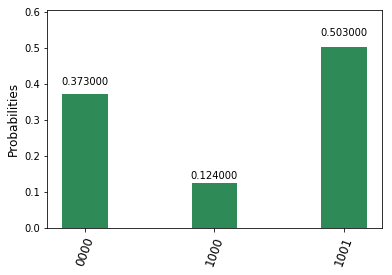

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg cr[4];
u1(0.0) q[4];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[1];
cx q[1],q[0];
u2(0.0,3.141592653589793) q[0];
cx q[2],q[0];
u3(-6.283185307179586,1.5707963267948966,1.5707963267948966) q[0];
u1(6.283185307179586) q[2];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[0];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[0];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[0];
cx q[2],q[4];
u3(-1.5707963267948966,0.0,-0.0) q[4];
cx q[2],q[4];
u2(0.0,0.0) q[4];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[0];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[0];
cx q[2],q[4];
u3(-0.523598775598299,0.0,-0.0) q[4

In [817]:
# Plotting
# import state tomography functions
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.tools.visualization import plot_histogram, plot_state
plot_histogram(result.get_counts('b_zero_ls_measureX'))
print(result.get_ran_qasm('b_zero_ls_measureX'))

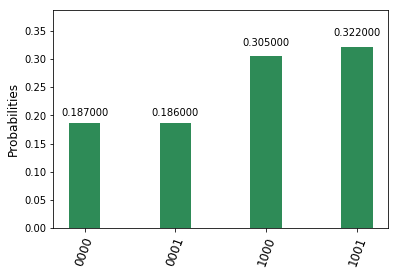

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg cr[4];
u1(0.0) q[4];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[1];
cx q[1],q[0];
u2(0.0,3.141592653589793) q[0];
cx q[2],q[0];
u3(-6.283185307179586,1.5707963267948966,1.5707963267948966) q[0];
u1(6.283185307179586) q[2];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[0];
cx q[2],q[0];
u1(6.283185307179586) q[0];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[4];
u2(0.0,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[4];
cx q[2],q[4];
u2(0.0,3.141592653589793) q[4];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[4];
u2(0.0,3.141592653589793) q[2];
cx q[2],q[0];
u1(6.283185307179586) q[0];
u2(0.0,6.283185307179586) q[2];
cx q[2],q[0];
u2(0.0,3.141592653589793) q[0];
u2(3.141592653589793,3.141592653589793) q[2];
u2(0.0,3.141592653589793) q[4];
cx q[2],q[4];
u1(6.283185307179586) q[4];
u3(-0.5235987755982989,3.14159265358

In [819]:
plot_histogram(result.get_counts('b_zero_ls_measureY'))
print(result.get_ran_qasm('b_zero_ls_measureY'))

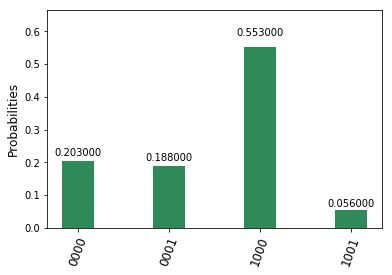

In [816]:
plot_histogram(result.get_counts('b_zero_ls_measureZ'))
print(result.get_ran_qasm('b_zero_ls_measureZ'))

In [820]:
# Expectation values
theoretical_expectation_values = {}
# X, Y, Z
theoretical_expectation_values['b_zero'] = {'X':-0.6, 'Y':0.0, 'Z':0.8}
theoretical_expectation_values['b_plus'] = {'X':1.0, 'Y':0.0, 'Z':0.0}
theoretical_expectation_values['b_minus'] = {'X':-1.0, 'Y':0.0, 'Z':0.0}

def expectation_values(b_key):    
    print('Expectation Values for b: ' + str(b_key))
    print('==============================================================')
    circuits = []
    for measure_key in measure_dict.keys():
        circuits.append(b_key + '_ls_' + measure_key)
        
    for circuit in circuits:
        result.get_counts(circuit)
        # Get results with 1 in the ancilla qubit q[3]
        try:
            x1 = result.get_counts(circuit)['1000']/shots
        except KeyError:
            x1 = 0
        try:
            x2 = result.get_counts(circuit)['1001']/shots
        except KeyError:
            x2 = 0

        # Scale the probabilities to add up to 1
        sum = x1 + x2
        x1 = x1/sum
        x2 = x2/sum
        expectation_value = x1-x2

        print('local simulator ' + circuit[-1] + ': ' + str(expectation_value) + ' | ' + \
              'theoretical ' + circuit[-1] + ': ' + str(theoretical_expectation_values[b_key][circuit[-1]]))
        print('--------------------------------------------------------------')

In [821]:
for b_key in b_val_dict.keys():
    expectation_values(b_key)

Expectation Values for b: b_zero
local simulator X: -0.6044657097288677 | theoretical X: -0.6
--------------------------------------------------------------
local simulator Y: -0.027113237639553478 | theoretical Y: 0.0
--------------------------------------------------------------
local simulator Z: 0.8160919540229884 | theoretical Z: 0.8
--------------------------------------------------------------
Expectation Values for b: b_plus
local simulator X: 1.0 | theoretical X: 1.0
--------------------------------------------------------------
local simulator Y: -0.064 | theoretical Y: 0.0
--------------------------------------------------------------
local simulator Z: 0.023622047244094502 | theoretical Z: 0.0
--------------------------------------------------------------
Expectation Values for b: b_minus
local simulator X: -1.0 | theoretical X: -1.0
--------------------------------------------------------------
local simulator Y: 0.006000000000000005 | theoretical Y: 0.0
------------------